In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc
import xgboost
from xgboost import XGBRegressor
import optuna

CPU times: user 1.92 s, sys: 987 ms, total: 2.9 s
Wall time: 2.26 s


In [2]:
df = pd.read_csv("train.csv")

test = pd.read_csv("test.csv")

test["num_sold"] = 0

combined = pd.concat([df, test])

In [3]:
dep_var = "num_sold"

In [4]:
holiday = pd.read_csv("nordic_holidays.csv")

In [5]:
holiday["holiday"] = str("in_") + holiday["country"]
display(holiday.head())

,Unnamed: 0,date,holiday,country
0,0,2016-01-01,in_Finland,Finland
1,1,2016-01-06,in_Finland,Finland
2,2,2016-03-25,in_Finland,Finland
3,3,2016-03-27,in_Finland,Finland
4,4,2016-03-28,in_Finland,Finland


In [6]:
combined = combined.merge(holiday[["date", "holiday", "country"]], left_on = ["date", "country"], right_on = ["date", "country"], how = "left")

combined["holiday"] = combined["holiday"].fillna("no_holiday")

In [7]:
country_map = pickle.load(open("embs/country_map.pkl", "rb"))
month_map = pickle.load(open("embs/month_map.pkl", "rb"))
product_map = pickle.load(open("embs/product_map.pkl", "rb"))
store_map = pickle.load(open("embs/store_map.pkl", "rb"))

In [8]:
emb_dim = country_map['Finland'].shape[0]
col_name = [f'country_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_country = pd.DataFrame(combined['country'].map(country_map).to_list(), columns = col_name)

emb_dim = product_map['Kaggle Mug'].shape[0]
col_name = [f'product_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_product = pd.DataFrame(combined['product'].map(product_map).to_list(), columns = col_name)

emb_dim = store_map['KaggleMart'].shape[0]
col_name = [f'store_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_store = pd.DataFrame(combined['store'].map(store_map).to_list(), columns = col_name)

In [9]:
combined.reset_index(drop = True, inplace = True)

In [10]:
combined = pd.concat([combined, df_emb_store, df_emb_product, df_emb_country], axis = 1)

In [11]:
combined[dep_var] = np.log(combined[dep_var])

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
combined = add_datepart(combined, 'date')

In [13]:
def find_weekend(df):
    '''this function finds whether the day is saturday or sunday i.e weekend
    1 - if saturday or sunday else 0
    '''
    weekends = []
    for i in df["Dayofweek"].values :
        if (i == 5) | (i == 6) :
            weekends.append(1)
        else :
            weekends.append(0)
    
    return weekends

In [14]:
weekends = find_weekend(combined)

In [19]:
weekends.count(0)

23472

In [20]:
weekends.count(1)

9396

In [21]:
combined["is_weekend"] = weekends

In [22]:
emb_dim = month_map[1].shape[0]
col_name = [f'month_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_month = pd.DataFrame(combined['Month'].map(month_map).to_list(), columns = col_name)

In [23]:
combined = pd.concat([combined, df_emb_month], axis = 1)

In [24]:
gdp = pd.read_csv("GDP_per_capita_2015_to_2019_Finland_Norway_Sweden.csv")

gdp = gdp.melt(id_vars = 'year', value_vars = ['Finland', 'Norway', 'Sweden'], var_name = 'country', value_name = 'gdp')

In [25]:
combined = combined.rename(columns = {"Year" : "year"})

In [26]:
combined = combined.merge(gdp, on = ["country", "year"], how = "left")

In [27]:
cond_tr = (combined.year < 2018)
cond_val = (combined.year == 2018)
train_idx = np.where(cond_tr)[0]
valid_idx = np.where(cond_val)[0]
test_idx = combined.iloc[26298:].index

In [28]:
len(train_idx), len(valid_idx), len(test_idx)

(19728, 6570, 6570)

In [29]:
cont, cat = cont_cat_split(combined, 1, dep_var)

In [30]:
cont

['row_id',
 'store_emb_1',
 'store_emb_2',
 'store_emb_3',
 'product_emb_1',
 'product_emb_2',
 'product_emb_3',
 'country_emb_1',
 'country_emb_2',
 'country_emb_3',
 'year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Elapsed',
 'is_weekend',
 'month_emb_1',
 'month_emb_2',
 'month_emb_3',
 'month_emb_4',
 'month_emb_5',
 'month_emb_6',
 'month_emb_7',
 'gdp']

In [31]:
cont.remove("row_id")
cont.remove("Elapsed")

In [32]:
procs = [Categorify, FillMissing, Normalize]
#train_idx = combined.iloc[:26298]
splits = (list(train_idx), list(valid_idx))
to = TabularPandas(combined, procs, cat, cont, y_names = dep_var, splits = splits)

In [33]:
def SMAPE(preds, targs):
    denominator = (targs + np.abs(preds)) / 200.0
    diff = np.abs(preds - targs) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [34]:
smape = AccumMetric(SMAPE, to_np = True)

In [35]:
dls = to.dataloaders(1024, device = "cuda")

In [36]:
learn = tabular_learner(dls, y_range = (3, 8), layers = [500, 250, 64, 32, 16], n_out = 1, metrics = [smape], loss_func = F.mse_loss)

CPU times: user 4.33 s, sys: 1.55 s, total: 5.88 s
Wall time: 5.85 s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0006918309954926372)

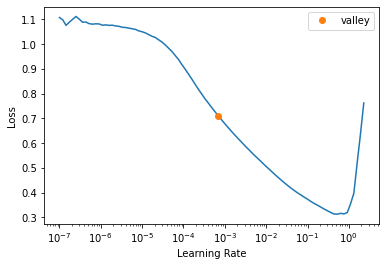

In [37]:
%%time
learn.lr_find()

In [38]:
learn.fit_one_cycle(10, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,SMAPE,time
0,0.212521,0.251190,6.810527,00:00
1,0.110396,0.018149,1.752707,00:00
2,0.064975,0.016142,1.686397,00:00
3,0.043114,0.015997,1.506923,00:00
4,0.030615,0.012347,1.439739,00:00
5,0.022611,0.010238,1.316070,00:00
6,0.017318,0.011881,1.432586,00:00
7,0.013689,0.010031,1.321909,00:00
8,0.011280,0.010849,1.383162,00:00
9,0.009599,0.010688,1.376162,00:00


CPU times: user 33.2 ms, sys: 1.17 ms, total: 34.4 ms
Wall time: 30.6 ms


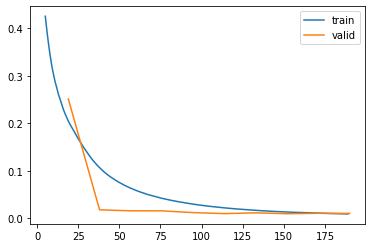

In [39]:
%%time
learn.recorder.plot_loss()

In [40]:
trainxs, trainy = to.train.xs, to.train.y
print (trainxs.shape, trainy.shape)

(19728, 34) (19728,)


In [41]:
validxs, validy = to.valid.xs, to.valid.y
print (validxs.shape, validy.shape)

(6570, 34) (6570,)


In [42]:
model_log = XGBRegressor(learning_rate = 0.44217554329478864, gamma = 0.008005901796296285,
                     alpha = 7.198845069865988, max_depth = 3,
                     reg_lambda = 0.002454298512769308)

In [43]:
model_log.fit(trainxs, trainy)

XGBRegressor(alpha=7.198845069865988, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=0.008005901796296285, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.44217554329478864, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=7, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=7.19884491,
             reg_lambda=0.002454298512769308, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
SMAPE(model_log.predict(validxs), validy)

1.5011186150104967

In [45]:
model_exp = XGBRegressor(learning_rate = 0.03939193777334498, gamma = 4.0544219317998165,
                     alpha = 5.32579150349582, max_depth = 8,
                     reg_lambda = 20.69660325703409)

In [46]:
trainy_exp = np.exp(trainy)
validy_exp = np.exp(validy)

In [47]:
model_exp.fit(trainxs, trainy_exp)

XGBRegressor(alpha=5.32579150349582, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=4.0544219317998165, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.03939193777334498, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=7, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=5.32579136, reg_lambda=20.69660325703409,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [48]:
SMAPE(model_exp.predict(validxs), validy_exp)

9.910916155637121

In [49]:
import pickle
pickle.dump(model_exp, open("models/model_exp.pkl", "wb"))
pickle.dump(model_log, open("models/model_log.pkl", "wb"))

In [50]:
learn.export("latest_nn.pkl")

In [51]:
ynn, _ = learn.get_preds()

In [52]:
ynn = np.concatenate([ynn])
ynn = np.squeeze(ynn)
ynn.shape

(6570,)

In [53]:
pred_exp = model_exp.predict(validxs)
pred_log = model_log.predict(validxs)

In [54]:
ynn = np.exp(ynn)

In [55]:
pred_log_exp = np.exp(pred_log)

In [56]:
final_pred = (pred_exp + pred_log_exp + ynn) / 3

In [57]:
final_pred[:5]

array([324.3741 , 510.88608, 144.00513, 547.1227 , 819.34937],
      dtype=float32)

In [58]:
SMAPE(final_pred, validy_exp)

6.858961736942309

In [59]:
from functools import partial
from scipy.optimize import fmin
class OptimizeSMAPE :
    def __init__(self):
        self.coef_ = 0
        
    def _smape(self, coef, X, y):
        '''
        coef = coef list, of the same length as the no of models
        X = predictions made by every model
        y = targets
        '''
        x_coef = X * coef
        predictions = np.sum(x_coef, axis = 1)
        # calculate the SMAPE score
        smape_score = SMAPE(predictions, y)
        
        return smape_score
    
    def fit(self, X, y):
        loss_partial = partial(self._smape, X = X, y = y)
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size = 1)
        
        self.coef_ = fmin(loss_partial, initial_coef, disp = True)
        
    def predict(self, X):
        x_coef = X * self.coef_
        predictions = np.sum(x_coef, axis = 1)
        return predictions

In [60]:
stack_preds = np.column_stack((pred_exp, pred_log_exp, ynn, final_pred))

In [61]:
opt = OptimizeSMAPE()

In [62]:
%%time
opt.fit(stack_preds[:, :-1], validy_exp)

Optimization terminated successfully.
         Current function value: 6.288618
         Iterations: 132
         Function evaluations: 231
CPU times: user 495 ms, sys: 14.4 ms, total: 510 ms
Wall time: 507 ms


In [63]:
opt.coef_

array([0.47459232, 0.30301865, 0.26701152])

In [64]:
combined_test = combined.iloc[test_idx]

In [65]:
procs = [Categorify, FillMissing, Normalize]
#train_idx = combined.iloc[:26298]
splits = (list(train_idx), list(test_idx))
to = TabularPandas(combined, procs, cat, cont, y_names = dep_var, splits = splits)

In [66]:
testxs = to.valid.xs

In [67]:
testxs.shape

(6570, 34)

In [68]:
dl = learn.dls.test_dl(combined_test)

In [69]:
testpred, _ = learn.get_preds(dl = dl)

/tmp/ipykernel_696/884952379.py:3: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(preds - targs) / denominator


In [70]:
testpred = np.concatenate([testpred])
testpred = np.squeeze(testpred)
testpred = np.exp(testpred)
testpred.shape

(6570,)

In [71]:
testpred_exp = model_exp.predict(testxs)

In [72]:
testpred_log = model_log.predict(testxs)
testpred_log = np.exp(testpred_log)

In [73]:
testpred_stack = np.column_stack((testpred_exp, testpred_log, testpred))

In [74]:
ensemble_test_preds = opt.predict(testpred_stack)

In [75]:
ensemble_test_preds

array([ 340.08412702,  524.23417278,  153.82872231, ...,  842.19041466,
       1164.88991635,  397.02881576])

In [76]:
submission = pd.read_csv("sample_submission.csv")

In [77]:
submission["num_sold"] = list(ensemble_test_preds)

In [78]:
submission.to_csv("subm/submission.csv", index = False)

In [79]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "plssssss"

100%|████████████████████████████████████████| 156k/156k [00:04<00:00, 32.7kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022

In [85]:
trainxs.head()

,country,store,product,holiday,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,...,Dayofyear,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
0,1,1,2,1,1,2,1,2,1,2,...,-1.727311,-1.730469,-0.427526,-0.610809,0.104252,0.285826,-0.070086,0.112347,0.85008,-1.126706
1,1,1,1,1,1,2,1,2,1,2,...,-1.727311,-1.730469,-0.427526,-0.610809,0.104252,0.285826,-0.070086,0.112347,0.85008,-1.126706
2,1,1,3,1,1,2,1,2,1,2,...,-1.727311,-1.730469,-0.427526,-0.610809,0.104252,0.285826,-0.070086,0.112347,0.85008,-1.126706
3,1,2,2,1,1,2,1,2,1,2,...,-1.727311,-1.730469,-0.427526,-0.610809,0.104252,0.285826,-0.070086,0.112347,0.85008,-1.126706
4,1,2,1,1,1,2,1,2,1,2,...,-1.727311,-1.730469,-0.427526,-0.610809,0.104252,0.285826,-0.070086,0.112347,0.85008,-1.126706


In [86]:
gdp.head()

,year,country,gdp
0,2015,Finland,42802
1,2016,Finland,43814
2,2017,Finland,46412
3,2018,Finland,50038
4,2019,Finland,48712


In [80]:
def feat_imp(model, df):
    return pd.DataFrame({'cols' : df.columns, 'imp' : model.feature_importances_}).sort_values(by = "imp", ascending = False)

In [81]:
combined_ = combined.drop(["row_id"], axis = 1)

In [82]:
combined_.drop(["num_sold", "Elapsed"], axis = 1, inplace = True)

In [83]:
combined_

,country,store,product,holiday,store_emb_1,store_emb_2,store_emb_3,product_emb_1,product_emb_2,product_emb_3,...,Is_year_start,is_weekend,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
0,Finland,KaggleMart,Kaggle Mug,in_Finland,0.967750,-0.929185,1.117330,-0.345529,-0.192691,-0.329195,...,True,0,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,42802
1,Finland,KaggleMart,Kaggle Hat,in_Finland,0.967750,-0.929185,1.117330,0.764051,0.657293,0.706160,...,True,0,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,42802
2,Finland,KaggleMart,Kaggle Sticker,in_Finland,0.967750,-0.929185,1.117330,-1.278340,-1.089227,-1.059847,...,True,0,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,42802
3,Finland,KaggleRama,Kaggle Mug,in_Finland,-0.300273,0.358641,-0.296122,-0.345529,-0.192691,-0.329195,...,True,0,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,42802
4,Finland,KaggleRama,Kaggle Hat,in_Finland,-0.300273,0.358641,-0.296122,0.764051,0.657293,0.706160,...,True,0,0.139456,0.072881,-0.318967,0.426407,0.222740,0.328248,0.634298,42802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32863,Sweden,KaggleMart,Kaggle Hat,in_Sweden,0.967750,-0.929185,1.117330,0.764051,0.657293,0.706160,...,False,0,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687
32864,Sweden,KaggleMart,Kaggle Sticker,in_Sweden,0.967750,-0.929185,1.117330,-1.278340,-1.089227,-1.059847,...,False,0,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687
32865,Sweden,KaggleRama,Kaggle Mug,in_Sweden,-0.300273,0.358641,-0.296122,-0.345529,-0.192691,-0.329195,...,False,0,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687
32866,Sweden,KaggleRama,Kaggle Hat,in_Sweden,-0.300273,0.358641,-0.296122,0.764051,0.657293,0.706160,...,False,0,0.133122,-0.090387,0.225697,-0.282197,-0.173948,0.021887,0.936223,51687


In [84]:
fi = feat_imp(model_log, combined_)

In [85]:
fi[:10]

,cols,imp
1,store,0.291951
2,product,0.277950
16,Day,0.224557
26,month_emb_1,0.073922
33,gdp,0.027872
23,Is_year_end,0.027392
27,month_emb_2,0.027235
0,country,0.022159
24,Is_year_start,0.011748
32,month_emb_7,0.004631


In [86]:
fi_exp = feat_imp(model_exp, combined_)

In [87]:
fi_exp[:10]

,cols,imp
2,product,0.538681
16,Day,0.188865
1,store,0.147735
26,month_emb_1,0.048270
24,Is_year_start,0.028713
33,gdp,0.012994
23,Is_year_end,0.006804
0,country,0.005830
21,Is_quarter_end,0.005497
31,month_emb_6,0.003767


In [100]:
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)
pd.set_option('display.width',1000)

In [101]:
combined.head()

,row_id,country,store,product,num_sold,holiday,store_emb_1,store_emb_2,store_emb_3,product_emb_1,product_emb_2,product_emb_3,country_emb_1,country_emb_2,country_emb_3,year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
0,0,Finland,KaggleMart,Kaggle Mug,5.796058,in_Finland,0.967750,-0.929185,1.117330,-0.345529,-0.192691,-0.329195,-0.885037,0.88509,-0.866939,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
1,1,Finland,KaggleMart,Kaggle Hat,6.253829,in_Finland,0.967750,-0.929185,1.117330,0.764051,0.657293,0.706160,-0.885037,0.88509,-0.866939,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
2,2,Finland,KaggleMart,Kaggle Sticker,4.983607,in_Finland,0.967750,-0.929185,1.117330,-1.278340,-1.089227,-1.059847,-0.885037,0.88509,-0.866939,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
3,3,Finland,KaggleRama,Kaggle Mug,6.349139,in_Finland,-0.300273,0.358641,-0.296122,-0.345529,-0.192691,-0.329195,-0.885037,0.88509,-0.866939,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802
4,4,Finland,KaggleRama,Kaggle Hat,6.814543,in_Finland,-0.300273,0.358641,-0.296122,0.764051,0.657293,0.706160,-0.885037,0.88509,-0.866939,2015,1,1,1,3,1,False,True,False,True,False,True,1.420070e+09,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,42802


In [109]:
combined["Dayofweek"].unique()

array([3, 4, 5, 6, 0, 1, 2])

## Fitting the entire dataset on the final model selected

In [88]:
model_exp_full = XGBRegressor(learning_rate = 0.03939193777334498, gamma = 4.0544219317998165,
                     alpha = 5.32579150349582, max_depth = 8,
                     reg_lambda = 20.69660325703409)

In [89]:
test_idx

Int64Index([26298, 26299, 26300, 26301, 26302, 26303, 26304, 26305, 26306,
            26307,
            ...
            32858, 32859, 32860, 32861, 32862, 32863, 32864, 32865, 32866,
            32867],
           dtype='int64', length=6570)

In [90]:
combined.iloc[:26298].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            26288, 26289, 26290, 26291, 26292, 26293, 26294, 26295, 26296,
            26297],
           dtype='int64', length=26298)

In [91]:
procs = [Categorify, FillMissing, Normalize]
train_idx = combined.iloc[:26298].index
splits = (list(train_idx), list(test_idx))
to = TabularPandas(combined, procs, cat, cont, y_names = dep_var, splits = splits)

In [92]:
cat

['country',
 'store',
 'product',
 'holiday',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [93]:
cont

['store_emb_1',
 'store_emb_2',
 'store_emb_3',
 'product_emb_1',
 'product_emb_2',
 'product_emb_3',
 'country_emb_1',
 'country_emb_2',
 'country_emb_3',
 'year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'is_weekend',
 'month_emb_1',
 'month_emb_2',
 'month_emb_3',
 'month_emb_4',
 'month_emb_5',
 'month_emb_6',
 'month_emb_7',
 'gdp']

In [94]:
fulltrainxs, fulltrainy = to.train.xs, to.train.y
print (fulltrainxs.shape, fulltrainy.shape)

(26298, 34) (26298,)


In [97]:
fulltrainy_exp = np.exp(fulltrainy)

In [98]:
model_exp_full.fit(fulltrainxs, fulltrainy_exp)

XGBRegressor(alpha=5.32579150349582, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=4.0544219317998165, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.03939193777334498, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=7, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=5.32579136, reg_lambda=20.69660325703409,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [96]:
model_log_full = XGBRegressor(learning_rate = 0.44217554329478864, gamma = 0.008005901796296285,
                     alpha = 7.198845069865988, max_depth = 3,
                     reg_lambda = 0.002454298512769308)

In [99]:
model_log_full.fit(fulltrainxs, fulltrainy)

XGBRegressor(alpha=7.198845069865988, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=0.008005901796296285, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.44217554329478864, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=7, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=7.19884491,
             reg_lambda=0.002454298512769308, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
procs = [Categorify, FillMissing, Normalize]
train_idx = combined.iloc[:26298].index
combined_train = combined.iloc[train_idx]
to_full = TabularPandas(combined_train, procs, cat, cont, y_names = dep_var, splits = None)

In [101]:
dls_full = to_full.dataloaders(1024, device = "cuda")

In [103]:
dls_full.train.y.min(), dls_full.train.y.max()

(4.248495, 7.9669337)

In [104]:
learn_full = tabular_learner(dls_full, y_range = (3, 8), layers = [500, 250, 64, 32, 16], n_out = 1,
                             metrics = [smape], loss_func = F.mse_loss)

/opt/conda/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0008317637839354575)

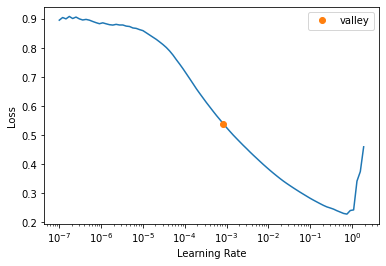

In [105]:
learn_full.lr_find()

In [106]:
learn_full.fit_one_cycle(10, slice(1e-4, 1e-1))

epoch,train_loss,valid_loss,SMAPE,time
0,0.069111,None,None,00:00
1,0.035615,None,None,00:00
2,0.026097,None,None,00:00
3,0.019073,None,None,00:00
4,0.014521,None,None,00:00
5,0.011865,None,None,00:00
6,0.010476,None,None,00:00
7,0.008904,None,None,00:00
8,0.007805,None,None,00:00
9,0.006882,None,None,00:00


In [107]:
testxs = to.valid.xs

In [108]:
testxs

,country,store,product,holiday,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,...,Dayofyear,is_weekend,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
26298,1,1,2,1,1,2,1,2,1,2,...,-1.727310,-0.633061,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26299,1,1,1,1,1,2,1,2,1,2,...,-1.727310,-0.633061,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26300,1,1,3,1,1,2,1,2,1,2,...,-1.727310,-0.633061,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26301,1,2,2,1,1,2,1,2,1,2,...,-1.727310,-0.633061,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
26302,1,2,1,1,1,2,1,2,1,2,...,-1.727310,-0.633061,-0.427732,-0.610998,0.104386,0.285907,-0.070123,0.112406,0.849990,-0.719467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32863,3,1,1,3,2,1,2,1,2,1,...,1.724934,-0.633061,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111
32864,3,1,3,3,2,1,2,1,2,1,...,1.724934,-0.633061,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111
32865,3,2,2,3,2,1,2,1,2,1,...,1.724934,-0.633061,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111
32866,3,2,1,3,2,1,2,1,2,1,...,1.724934,-0.633061,-0.442045,-0.992988,1.631092,-2.626758,-1.602018,-1.144038,1.315813,-0.492111


In [109]:
pred_log = model_log_full.predict(testxs)

In [112]:
pred_log = np.exp(pred_log)

In [113]:
pred_exp = model_exp_full.predict(testxs)

In [114]:
pred_exp

array([ 386.0896 ,  552.13116,  173.03183, ...,  839.2699 , 1252.8414 ,
        373.08298], dtype=float32)

In [115]:
combined_test.head(2)

,row_id,country,store,product,num_sold,holiday,store_emb_1,store_emb_2,store_emb_3,product_emb_1,...,Elapsed,is_weekend,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7,gdp
26298,26298,Finland,KaggleMart,Kaggle Mug,-inf,in_Finland,0.96775,-0.929185,1.11733,-0.345529,...,1.546301e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,48712
26299,26299,Finland,KaggleMart,Kaggle Hat,-inf,in_Finland,0.96775,-0.929185,1.11733,0.764051,...,1.546301e+09,0,0.139456,0.072881,-0.318967,0.426407,0.22274,0.328248,0.634298,48712


In [117]:
dl = learn_full.dls.test_dl(combined_test)

In [118]:
dl

In [121]:
ynn_full, _ = learn_full.get_preds(dl = dl)

/tmp/ipykernel_696/884952379.py:3: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(preds - targs) / denominator


In [123]:
ynn_full = np.concatenate([ynn_full])
ynn_full = np.squeeze(ynn_full)
ynn_full = np.exp(ynn_full)
ynn_full.shape

(6570,)

In [124]:
ynn_full

array([ 397.54956,  612.40027,  182.40225, ...,  966.533  , 1383.3839 ,
        424.8355 ], dtype=float32)

In [125]:
basic_blend = (ynn_full + pred_exp + pred_log) / 3

In [126]:
basic_blend

array([ 383.87003,  569.9206 ,  170.65169, ...,  919.1048 , 1312.3032 ,
        400.11533], dtype=float32)

In [127]:
submission["num_sold"] = list(basic_blend)

In [128]:
submission.to_csv("subm/submission.csv", index = False)

In [129]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "plssssss"

100%|████████████████████████████████████████| 101k/101k [00:04<00:00, 20.9kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022

In [130]:
opt.coef_

array([0.47459232, 0.30301865, 0.26701152])

In [131]:
testpred_stack = np.column_stack((pred_exp, pred_log, ynn_full))

In [132]:
final_pred = opt.predict(testpred_stack)

In [133]:
final_pred

array([ 400.88751427,  590.77004773,  178.25186657, ...,  944.71222513,
       1358.09993973,  412.44130924])

In [134]:
submission["num_sold"] = list(final_pred)

In [135]:
submission.to_csv("subm/submission.csv", index = False)

In [136]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f subm/submission.csv -m "plssssss"

100%|████████████████████████████████████████| 157k/157k [00:06<00:00, 24.7kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022